In [3]:
# Importações padrão do Python
from time import time

# Importações do Pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Importações do IPython
from IPython.display import Image, display

# Importações do Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,
    make_scorer
)

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.cluster import KMeans

# Importações de outras bibliotecas de aprendizado de máquina
import lightgbm as lgb

# Importações de outras utilidades
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import joblib
import warnings
warnings.filterwarnings("ignore")

# Configuração do Spark Session
spark = SparkSession.builder \
    .appName("My Spark App") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "6") \
    .config("spark.driver.maxResultSize", "4g") \
    .enableHiveSupport() \
    .getOrCreate()

# <b>Bruno Rodrigues - T718289 </b>
### Case do Data Master mar'24

<h1> <span style="color:orange"><b>SUMÁRIO</b></span></h1>

<h3><b> Capítulo 1 </b>- Introdução </h3>
<p>1.1 Apresentação do Problema
<p>1.2 Definição da Target
<p>1.3 Oportunidade

<h1> <span style="color:orange"><b> Capítulo 1 </b> </span>- Introdução</h1>
<h2> <span style="color:red">1.1 - Modelo Classificação </span> </h2>
Uma empresa de streaming de música quer reduzir o número de cancelamentos de assinaturas. Foi proposto oferecer três meses de assinatura gratuita como um incentivo para os clientes que estão considerando cancelar seus planos. Esta abordagem demonstrou ser eficaz, com resultados mostrando que ela ajuda a reter 50% dos clientes que, de outra forma, cancelariam seus serviços.
<p>Para maximizar a eficiência desta estratégia, é crucial <b>implementar um sistema de previsão que identifique proativamente os clientes que vão cancelar a assinatura</b>. Assim, podemos direcionar nossa oferta de forma mais precisa e manter uma base de clientes mais estável.


In [35]:
df_classification = spark.read.parquet("B:/Data Master/base_dados/members.parquet").select(F.col('msno'),F.col('safra'),F.col('is_ativo').alias('ativo_M0'))

# Base auxiliar para marcar o Churn M3
df_aux = df_classification.withColumn('inativo_M3', F.when(F.col('ativo_M0')==1, 0).otherwise(1)).drop('ativo_M0')
df_aux = df_aux.withColumn('safra', F.date_format(F.add_months(F.to_date(F.col("safra"),"yyyyMM") ,-3), "yyyyMM"))

# Cruza as bases para marcar na origem
df_classification = df_classification.join(df_aux, how='left', on=['msno', 'safra']).where("ativo_M0=1").drop('ativo_M0').fillna(1)
df_classification.write.partitionBy('safra').save("B:/Data Master/base_dados/table_classification")
df_classification.show(5, False)

+--------------------------------------------+------+----------+
|msno                                        |safra |inativo_M3|
+--------------------------------------------+------+----------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|1         |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|1         |
|++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI=|201610|1         |
|++BW1PJYU5OZi3n3+IDLiU+d1IL1VE/GLx6p64TDs6U=|201607|0         |
|++Bks8kE9oclzxZM3hcWs+qzsxuoXFeIE1+7pxKBCQg=|201607|0         |
+--------------------------------------------+------+----------+
only showing top 5 rows



In [127]:
df_classification = pd.read_parquet("B:/Data Master/base_dados/table_classification")
df_classification['qtde'] = 1
cubo_classification = pd.pivot_table(df_classification, values='qtde', index='safra', columns='inativo_M3', aggfunc='sum', fill_value=0, sort=True).reset_index()
cubo_classification = cubo_classification[cubo_classification['safra'].astype(int)<=201609]
cubo_classification['churn M3'] = cubo_classification[1]/(cubo_classification[1]+cubo_classification[0])*100

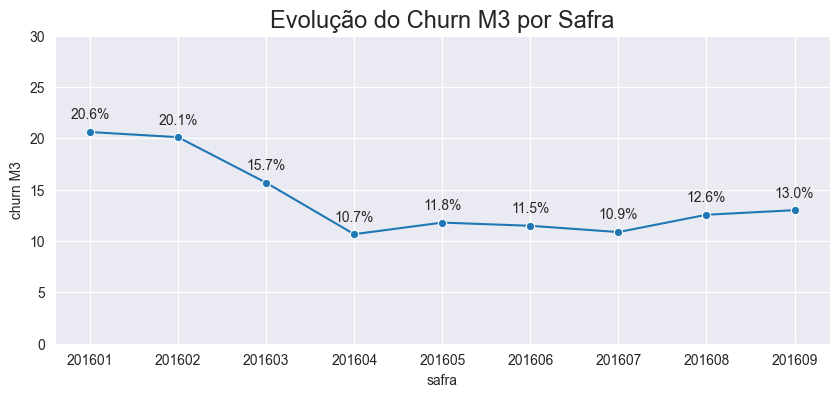

In [126]:
plt.figure(figsize=(10, 4))  # Definindo o tamanho do gráfico
ax = sns.lineplot(data=cubo_classification, x="safra", y="churn M3",  marker='o')
plt.ylim(0, 30)
plt.title('Evolução do Churn M3 por Safra', size=17)
plt.xticks(ticks=cubo_classification['safra'], labels=cubo_classification['safra'].apply(str))   
for x, y in zip(cubo_classification['safra'], cubo_classification['churn M3']):
    plt.text(x, y+1, f'{y:.1f}%', ha='center', va='bottom')
plt.show()

- <i>foi removido os clientes inativos na origem
- em média 14% da base de clientes ativos são CHURN_M3, ou seja, eles cancelaram seus planos.
- oportunidade de evitar o cancelamento de 131mil por mês
<h2> <span style="color:red">1.2 - Modelo Regressão </span> </h2>
 O comitê executivo precisa de visibilidade de 
rentabilidade das assinaturas dos clientes para 
antecipar tendencias.
<p>O custo é dado por:
<b> C(u,t)=50+0.0051u+0.0001t </b>
 em que u é a quantidade de músicas únicas que o 
cliente ouviu no mês de referência e t é o tempo 
total em segundos que o cliente ouviu no mesmo 
período;
<p>Desenvolva um modelo para estimar a Margem 
Líquida (Preço –Custo) do produto e avalie sua 
performance em M1

In [155]:
df_log = (spark.read.parquet("B:/Data Master/base_dados/user_logs.parquet")
                .select(F.col('msno'),
                        F.col('safra'),
                          (F.col('num_unq')*0.0051+F.col('total_secs')*0.0001+50).cast('int').alias('custo'))
                .where("safra>=201602 and safra<=201701")
        )

df_transactions = (spark.read.parquet("B:/Data Master/base_dados/transactions.parquet")
                        .select(F.col('msno'), 
                                F.col('safra'), 
                                (F.col('plan_list_price')/F.col('payment_plan_days')*30).cast('int').alias('preco'))
                        .where("safra>=201602 and safra<=201701 and plan_list_price>0")
                    )

df_regression = df_transactions.join(df_log, how='inner', on=['msno', 'safra']).fillna(-1)
df_regression = (df_regression
                    .withColumn('safra', F.date_format(F.add_months(F.to_date(F.col("safra"),"yyyyMM") ,-1), "yyyyMM"))
                    .withColumn('margem_liquida', F.col('preco')-F.col('custo'))
                    .drop('preco', 'custo')
                    .where("margem_liquida>0")
                    )

df_regression.write.partitionBy('safra').save("B:/Data Master/base_dados/table_regression")
df_regression.show(5, False)

+--------------------------------------------+------+--------------+
|msno                                        |safra |margem_liquida|
+--------------------------------------------+------+--------------+
|++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=|201605|81            |
|++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=|201606|93            |
|++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=|201610|96            |
|++2KAIaZigu6bS4t+s7o/TS1Ki6IVWZBnJCh5day67c=|201607|118           |
|++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=|201606|87            |
+--------------------------------------------+------+--------------+
only showing top 5 rows



<Axes: xlabel='margem_liquida', ylabel='safra'>

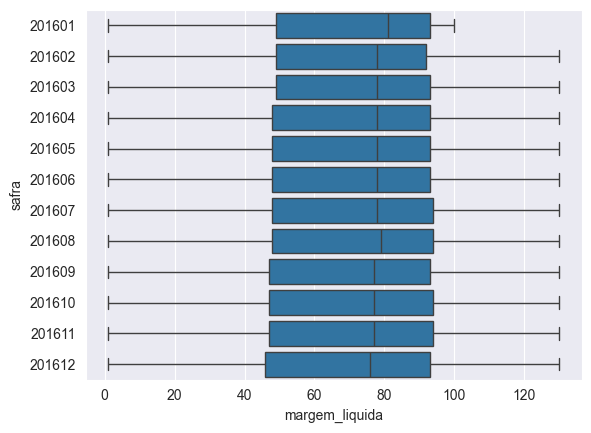

In [89]:
df_regression = pd.read_parquet("B:/Data Master/base_dados/table_regression")
seaborn.boxplot(x="margem_liquida", y="safra", data=df_regression)

<h2> <span style="color:red"> 1.3 Modelos Não Supervisionado </span>
<h1> <span style="color:orange"><b> Capítulo 2 </b></span>- Criação das Variáveis
<h3><p>2.1 - Variáveis da LOG</h3>

A base de LOG contém informações históricas do comportamento de uso do streaming de música.

<b>Variáveis Originais</b>
- num_25    - quantidade de músicas tocadas menos 25% do comprimento
- num_50    - quantidade de músicas tocadas no intervalor de 25% até 50% do comprimento
- num_75    - quantidade de músicas tocadas no intervalor de 50% até 75% do comprimento
- num_985   - quantidade de músicas tocadas no intervalor de 75% até 985% do comprimento
- num_100   - quantidade de músicas tocadas acima 98.5% do comprimento
- num_unq   - quantidade de músicas unicas tocadas
- total_secs - quantidade de segundos tocados de música

<b>Utilização de Histórico</b>
- M01   - último mês de informação
- M03   - últimos 3 meses de informação 
- M06   - últimos 6 meses de informação 
- M09   - últimos 9 meses de informação 
- M12   - últimos 12 meses de informação 

<b>Métodos de Agregação do Histórico</b>
- sum    - soma dos valores do período  
- min    - máximo dos valores do período
- max    - mínimo dos valores do período
- median - mediana dos valores do período
- std    - desvio padrãp dos valores do período
- corr   - correlação dos valores com relação safra  
<p><b>exemplo:</b>
<p><i>num_unq_min_M12 - número mínimo de músicas unicas ouvidas em um mês dos últimos 12 meses</i>

<span style="background-color: red;"> <b>TOTAL:</b> 157 variáveis da LOG

In [8]:
window = Window.partitionBy("msno").orderBy("safra")

# Importatar a tabela LOG em spark para acelerar o processamento
df_log = (spark.read.parquet("B:/Data Master/base_dados/user_logs.parquet")
            .select(
                F.col('msno'),
                F.col('safra').cast('int'),
                F.col('num_25').cast('int'),
                F.col('num_50').cast('int'),
                F.col('num_75').cast('int'),
                F.col('num_985').cast('int'),
                F.col('num_100').cast('int'),
                F.col('num_unq').cast('int'),
                F.col('total_secs').cast('int')
            )
            #Variaveis auxiliares
            .withColumn('qtde', F.lit(1))
            .withColumn("rank", F.rank().over(window))
          )

# df_log.write.partitionBy('safra').save("B:/Data Master/base_dados/table_LOG_total")

In [19]:
df_log.describe(['total_secs']).show()

+-------+-------------------+
|summary|         total_secs|
+-------+-------------------+
|  count|           26758971|
|   mean|-3274694.3666117056|
| stddev| 8.54185526181561E7|
|    min|        -2147483648|
|    max|         2147483647|
+-------+-------------------+



In [23]:
df_log.filter(F.col('total_secs')>2500000).count()/df_log.count()*100

0.010168552445458385

In [160]:
# Dicionários auxiliares para filtrar períodos e operações
ref_escoragem = {
    201601: {'M01':[201512], 
             'M03':[201512, 201511, 201510], 
             'M06':[201512, 201511, 201510, 201509, 201508, 201507], 
             'M09':[201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505, 201504], 
             'M12':[201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505, 201504, 201503, 201502, 201501]},

    201602: {'M01':[201601], 
             'M03':[201601, 201512, 201511], 
             'M06':[201601, 201512, 201511, 201510, 201509, 201508], 
             'M09':[201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505], 
             'M12':[201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505, 201504, 201503, 201502]},
    
    201603: {'M01':[201602], 
             'M03':[201602, 201601, 201512],
             'M06':[201602, 201601, 201512, 201511, 201510, 201509], 
             'M09':[201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506], 
             'M12':[201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505, 201504, 201503]},
        
    201604: {'M01':[201603], 
             'M03':[201603, 201602, 201601], 
             'M06':[201603, 201602, 201601, 201512, 201511, 201510], 
             'M09':[201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507], 
             'M12':[201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505, 201504]},

    201605: {'M01':[201604], 
             'M03':[201604, 201603, 201602], 
             'M06':[201604, 201603, 201602, 201601, 201512, 201511], 
             'M09':[201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508], 
             'M12':[201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506, 201505]},

    201606: {
             'M01':[201605], 
             'M03':[201605, 201604, 201603], 
             'M06':[201605, 201604, 201603, 201602, 201601, 201512], 
             'M09':[201605, 201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509], 
             'M12':[201605, 201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507, 201506]},

    201607: {'M01':[201606], 
             'M03':[201606, 201605, 201604], 
             'M06':[201606, 201605, 201604, 201603, 201602, 201601], 
             'M09':[201606, 201605, 201604, 201603, 201602, 201601, 201512, 201511, 201510], 
             'M12':[201606, 201605, 201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508, 201507]},

    201608: {'M01':[201607], 
             'M03':[201607, 201606, 201605], 
             'M06':[201607, 201606, 201605, 201604, 201603, 201602], 
             'M09':[201607, 201606, 201605, 201604, 201603, 201602, 201601, 201512, 201511], 
             'M12':[201607, 201606, 201605, 201604, 201603, 201602, 201601, 201512, 201511, 201510, 201509, 201508]},

    201609: {'M01':[201608], 
             'M03':[201608, 201607, 201608], 
             'M06':[201608, 201607, 201608, 201607, 201606, 201605], 
             'M09':[201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603, 201602], 
             'M12':[201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603, 201602, 201601, 201512, 201511]},

    201610: {
             'M01':[201609], 
             'M03':[201609, 201608, 201607], 
             'M06':[201609, 201608, 201607, 201608, 201607, 201606], 
             'M09':[201609, 201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603], 
             'M12':[201609, 201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603, 201602, 201601, 201512]},

    201611: {
             'M01':[201610], 
             'M03':[201610, 201609, 201608], 
             'M06':[201610, 201609, 201608, 201607, 201608, 201607], 
             'M09':[201610, 201609, 201608, 201607, 201608, 201607, 201606, 201605, 201604], 
             'M12':[201610, 201609, 201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603, 201602, 201601]},

    201612: {'M01':[201611], 
             'M03':[201611, 201610, 201609], 
             'M06':[201611, 201610, 201609, 201608, 201607, 201608], 
             'M09':[201611, 201610, 201609, 201608, 201607, 201608, 201607, 201606, 201605], 
             'M12':[201611, 201610, 201609, 201608, 201607, 201608, 201607, 201606, 201605, 201604, 201603, 201602]}
}

metodo_agregacao  = {
            'num_25'  :    ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'num_50'  :    ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'num_75'  :    ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'num_100' :    ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'num_unq' :    ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'total_secs' : ['sum', 'min', 'max', 'std', 'median', 'corr'],
            'qtde' : ['sum']
}

variaveis_M1 = ['msno', 'num_25_M01', 'num_50_M01', 'num_75_M01', 'num_985_M01', 'num_100_M01', 'num_unq_M01', 'total_secs_M01', 'safra']

In [170]:
dfs = {}
for i in ref_escoragem.keys():
    dfs[i] = {}

    for j in ref_escoragem[i].keys():
        ini = min(ref_escoragem[i][j])
        fim = max(ref_escoragem[i][j])
        df_filtrado = spark.read.parquet("B:/Data Master/base_dados/table_LOG_total").where(f'safra>={ini} and safra<={fim}')

        if j == 'M01':
            dfs[i][j] = df_filtrado.drop('qtde', 'rank')
            dfs[i][j] = dfs[i][j].withColumn('safra', F.lit(i).cast('int'))
            for old_col, new_col in zip(df_filtrado.columns, variaveis_M1):
                dfs[i][j] = dfs[i][j].withColumnRenamed(old_col, new_col)
            dfs[i][j].write.save(f"B:/Data Master/base_dados/VAR_log/table_LOG_{i}_{j}")
            dfs[i][j].unpersist()
        else:
            dfs[i][j] = df_filtrado.withColumn('safra', F.lit(i).cast('int'))
            agg_exprs = []
            for col, funcs in metodo_agregacao.items():
                for func in funcs:
                    if func == 'sum':
                        agg_exprs.append(F.sum(col).alias(f'{col}_sum_{j}'))
                    elif func == 'min':
                        agg_exprs.append(F.min(col).alias(f'{col}_min_{j}'))
                    elif func == 'max':
                        agg_exprs.append(F.max(col).alias(f'{col}_max_{j}'))
                    elif func == 'std':
                        agg_exprs.append(F.round(F.stddev(col),2).alias(f'{col}_stddev_{j}'))
                    elif func == 'corr':
                        agg_exprs.append(F.round(F.corr(col, 'rank'),2).alias(f'{col}_pearson_{j}'))
                    elif func == 'median':
                        agg_exprs.append(F.median(col).alias(f'{col}_median_{j}'))

            dfs[i][j] = dfs[i][j].groupBy(['msno', 'safra']).agg(*agg_exprs).fillna(0)
            dfs[i][j].write.save(f"B:/Data Master/base_dados/VAR_log/table_LOG_{i}_{j}")
            dfs[i][j].unpersist()

In [174]:
dfs = {}
for i in ref_escoragem.keys():
    dfs[i] = {}
    for j in ref_escoragem[i].keys():
        dfs[i][j] = spark.read.parquet(f"B:/Data Master/base_dados/VAR_log/table_LOG_{i}_{j}")

# Concatenar e agrupar os DataFrames no nível de 'i'
    dfs_concat = [dfs[i][j] for j in ref_escoragem[i].keys()]
    dfs[i]['final'] = dfs_concat[0]
    for df in dfs_concat[1:]:
        dfs[i]['final'] = dfs[i]['final'].unionByName(df, allowMissingColumns=True)

    agg_final = []
    for col in dfs[i]['final'].columns:
        if col!='msno' and col!='safra':
            agg_final.append(F.sum(col).alias(col))
            
    dfs[i]['final'] = dfs[i]['final'].groupBy(['msno', 'safra']).agg(*agg_final)

    dfs[i]['final'].write.save(f"B:/Data Master/base_dados/VAR_log/table_LOG_{i}")

<h3> <p>2.2 - Tabelas de Membros</h3>

- tempo de registro -  Diferença entre a data atual e a data de registro em meses 
- city - cidade 
- idade - corrigido todos outilers para mediana (preenchido somente para 38% do público)
- canal_registro - código do canal_registro

+ Adicionar um texto com a explicação do porque usar variáveis WoE

<span style="background-color: red;"> TOTAL: 4 variáveis de CADASTRO </span>


In [85]:
# Ler os dados e selecionar as colunas necessárias e renomear as variáveis
df_members = (
    spark.read.parquet("B:/Data Master/base_dados/members.parquet")
    .select(
        F.col('msno'), 
        F.col('safra').cast('int'), 
        F.col('registration_init_time').alias('tempo_rel').cast('int'), 
        F.col('city').alias('cidade').cast('int'), 
        F.col('bd').alias('idade').cast('int'), 
        F.col('registered_via').alias('canal_registro').cast('int'),
    )
    # Transforma uma data em uma variável continua
    .withColumn('tempo_rel', F.months_between(F.to_date(F.col("safra"), "yyyyMM"), F.to_date(F.col("tempo_rel"), "yyyyMMdd")).cast('int'))
    # Tratar os valores missing da idade, preenchendo com a mediana
    .withColumn('idade', F.when((F.col('idade') < 1) | (F.col('idade') > 120), 27).otherwise(F.col('idade')).cast('int'))
)

df_members.write.partitionBy('safra').save("B:/Data Master/base_dados/VAR_members")
df_members.show(5, False)

+--------------------------------------------+------+---------+------+-----+--------------+
|msno                                        |safra |tempo_rel|cidade|idade|canal_registro|
+--------------------------------------------+------+---------+------+-----+--------------+
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201612|26       |1     |27   |7             |
|++/AwGzubug3gT6J+0STBGMdWKxaM+UFZTI8Tcmq4To=|201607|15       |1     |27   |9             |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201601|36       |15    |32   |3             |
|++02XbtviomSxcIBUHMOiJkjRxdicTXSfiVqLdsr5lo=|201603|27       |14    |21   |7             |
|++0O0Bq04sB/9ZcOS+pajpYL2Hin9jCqnc/8bKzKFuE=|201610|23       |5     |33   |3             |
+--------------------------------------------+------+---------+------+-----+--------------+
only showing top 5 rows



<h3> 2.3 - Tabelas de Transação </h3>

A tabela de transação tem informação sobre o método de pagamento; tipo de plano; renovação automatica e tempo para expirar o plano.
<p><span style="background-color: red;"> TOTAL: 4 variáveis da TRANSAÇÃO


In [80]:
# Ler os dados e selecionar as colunas necessárias e renomear as variáveis
df_transactions = (
    spark.read.parquet("B:/Data Master/base_dados/transactions.parquet")
    .select(
        F.col('msno'), 
        F.col('safra').cast('int'),
        F.col('payment_method_id').alias('metodo_pgto').cast('int'), 
        F.col('payment_plan_days').alias('tp_plano').cast('int'),         
        F.col('is_auto_renew').alias('auto_renovacao').cast('int'), 
        F.col('membership_expire_date').alias('temp_exp_plano').cast('int')
    )
    # Calcular a diferença entre a data atual e a data de registro em meses para aplicação em ML
    .withColumn('temp_exp_plano', -F.months_between(F.to_date(F.col("safra"), "yyyyMM"), F.to_date(F.col("temp_exp_plano"), "yyyyMMdd")).cast('int'))
)

df_transactions.write.partitionBy('safra').save("B:/Data Master/base_dados/VAR_transactions")
df_transactions.show(5, False)

+--------------------------------------------+------+-----------+--------+--------------+--------------+
|msno                                        |safra |metodo_pgto|tp_plano|auto_renovacao|temp_exp_plano|
+--------------------------------------------+------+-----------+--------+--------------+--------------+
|+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=|201511|38         |410     |0             |14            |
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201505|41         |30      |1             |1             |
|+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=|201509|41         |30      |1             |1             |
|++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=|201606|41         |30      |1             |1             |
|++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=|201501|40         |31      |1             |1             |
+--------------------------------------------+------+-----------+--------+--------------+--------------+
only showing top 5 rows



<h3>2.4 - Montagem da Master

In [9]:
safras = [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612]

dfs = {}
for i in safras:
    dfs[i] = spark.read.parquet(f"B:/Data Master/base_dados/VAR_log/table_LOG_{i}")

dfs_concat = [dfs[i] for i in safras]
df_var_log = dfs_concat[0]
for df in dfs_concat[1:]:
    df_var_log = df_var_log.unionByName(df, allowMissingColumns=True)

df_var_members = spark.read.parquet("B:/Data Master/base_dados/VAR_members")
df_var_transactions = spark.read.parquet("B:/Data Master/base_dados/VAR_transactions")
df_classification = spark.read.parquet("B:/Data Master/base_dados/table_classification")
df_regression = spark.read.parquet("B:/Data Master/base_dados/table_regression")

In [15]:
df_master = (
    df_classification
    .join(df_regression, how='inner', on=['msno', 'safra'])
    .join(df_var_members, how='left', on=['msno', 'safra'])
    .join(df_var_transactions, how='left', on=['msno', 'safra'])    
    .join(df_var_log, how='left', on=['msno', 'safra'])
).fillna(-1).persist()

df_master.write.partitionBy('safra').save("B:/Data Master/base_dados/master_table")

<h1> <h1> <span style="color:orange"><b> Capítulo 3 </b></span>- Modelos de Classificação e Regressão

| Etapa  | perc. população |
| :--------- |------:| 
| Treino  | 70%
| Teste   | 30% 

In [31]:
df_master = pd.read_parquet("B:/Data Master/base_dados/master_table")

In [33]:
df_master.filter(F.col('total_secs_M01').cast('int')>=2500000)
# .count()

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

In [84]:
# Carregar a master e filtrar somente o período de teste e treino
df_master = pd.read_parquet("B:/Data Master/base_dados/master_table")

# Garantir os que sejam clientes unicos dentro dos 3 meses
df_master = df_master.sample(frac=1)
df_master.drop_duplicates(subset=['msno'], inplace=True)

# Separar em treino e Teste
df_train, df_test = train_test_split(df_master, test_size=0.30, random_state=42)

X_train, y_train_clf, y_train_reg = df_train.drop(['msno', 'safra', 'inativo_M3', 'margem_liquida'], axis=1), df_train['inativo_M3'], df_train['margem_liquida']
X_test, y_test_clf, y_test_reg = df_test.drop(['msno', 'safra', 'inativo_M3', 'margem_liquida'], axis=1), df_test['inativo_M3'], df_test['margem_liquida']

# Liberar mémoria
del df_master

<h2><span style="color:red"><b>  3.1 - Modelo de Classificação </b></span> </h2>
<h3> 3.1.1 - Seleção de Variáveis <i>(Feature Importance)</i> </h3>
<p>O Random Forest é uma técnica amplamente utilizada para essa finalidade devido à sua capacidade de avaliar a importância relativa das variáveis. Durante o treinamento do Random Forest, cada variável é examinada quanto à sua contribuição para a redução da impureza nos nós das árvores de decisão. Com base nisso, o algoritmo atribui um valor de importância a cada variável. Utilizando essa informação, é possível estabelecer um critério para selecionar as variáveis mais importantes, descartando aquelas que não agregam valor significativo ao modelo. Essa abordagem objetiva e técnica do Random Forest na seleção de variáveis contribui para a construção de modelos mais precisos e eficientes.

In [24]:
# Treinar um modelo Random Forest para seleção de variáveis
clf = RandomForestClassifier(random_state=42, n_jobs=9, class_weight='balanced', max_depth=50, min_samples_split=500, min_samples_leaf=100, n_estimators=30)
clf.fit(X_train, y_train_clf)   

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
f1_train = round(f1_score(y_train_clf, y_pred_train),2)
f1_test = round(f1_score(y_test_clf, y_pred_test),2)

feature_importances = (clf.feature_importances_ / sum(clf.feature_importances_))*100

results = pd.DataFrame({
    'Features' : X_test.columns.tolist(),
    'Importances' : feature_importances
}).sort_values(['Importances'], axis=0, ascending=False)

results = results[results['Importances']>0.3]['Features'].tolist()

# Salvar a lista em um arquivo
with open('B:/Data Master/var_classificacao.txt', 'w') as arquivo:
    for item in results:
        arquivo.write(f"{item}\n")

print(f'Resultado do Modelo de Classificação')
print(f'f1 Treino:{f1_train}')
print(f'f1 Teste:{f1_test}')
print('')
print(f'Qtde. variáveis classificação:{len(results)}')

Resultado do Modelo de Classificação
f1 Treino:0.77
f1 Teste:0.76

Qtde. variáveis classificação:35


<h3> 3.1.2 - Escolha do Algoritmo de Machine Learning <i></h3>

In [3]:
# Como o XGBClassifier não tem o parametro class_weight, usei um pacote do sklearn para criar um vetor de pesos 
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_clf
)

In [4]:
# Filtrar somente as variáveis relevantes para predição
var_classificacao = []
with open('B:/Data Master/var_classificacao.txt', 'r') as arquivo:
    var_classificacao = arquivo.readlines()
    var_classificacao = [item.strip() for item in var_classificacao]  # Remover quebras de linha

In [39]:
def Classificador(nome, clf, X_train, y_train, X_test, y_test):
    start_time = time()
    clf.fit(X_train, y_train, sample_weight=classes_weights)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    duration = time() - start_time

    accuracy = accuracy_score(y_train, y_pred_train)
    precision = precision_score(y_train, y_pred_train)
    recall = recall_score(y_train, y_pred_train)
    roc_curve = roc_auc_score(y_train, y_pred_train)

    metricas_treino = pd.DataFrame({'Acuracia':accuracy, 'Precisao':precision, 'Recall':recall, 'AUC':roc_curve,'tempo':duration ,'Etapa':'treino', 'Classificador':nome}, index = np.arange(1))

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    roc_curve = roc_auc_score(y_test, y_pred_test)

    metricas_teste = pd.DataFrame({'Acuracia':accuracy, 'Precisao':precision, 'Recall':recall, 'AUC':roc_curve, 'tempo':duration ,'Etapa':'teste','Classificador':nome}, index = np.arange(1))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

In [40]:
clf_DecisionTree  = Classificador('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42), X_train[var_classificacao], y_train_clf, X_test[var_classificacao], y_test_clf)
clf_RandomForest  = Classificador('RandomForestClassifier', RandomForestClassifier(random_state=42, n_jobs=9), X_train[var_classificacao], y_train_clf, X_test[var_classificacao], y_test_clf)
clf_LightGBM = Classificador('LGBMClassifier', lgb.LGBMClassifier(random_state=42, verbose=-1, device_type='gpu'), X_train[var_classificacao], y_train_clf, X_test[var_classificacao], y_test_clf)

In [41]:
results_model = pd.concat([clf_DecisionTree, clf_RandomForest, clf_LightGBM])
results_model[results_model['Etapa']=='teste']

,Acuracia,Precisao,Recall,AUC,tempo,Etapa,Classificador
0,0.748417,0.675447,0.742803,0.747558,36.127726,teste,DecisionTreeClassifier
0,0.802458,0.771136,0.736335,0.792340,74.156371,teste,RandomForestClassifier
0,0.803338,0.742950,0.795011,0.802064,11.003404,teste,LGBMClassifier


O modelo escolhido foi <span style="background-color: red;"> LGBMClassifier </span>, pois apresenta o equilibrio entre acurácia e tempo de execução. O tempo de execução tem um bom desempenho por conta de contar com suporte de processamento com GPU.

<h3> 3.1.3 - Otimização dos Hiperparametros do Algoritmo <i></h3>

A função de custo \(C\) é definida por:

$$
C = 12 \times 0.5 \times TP - (TP + FP) \times 3
$$
Onde:
- \(TP\) é o número de verdadeiros positivos.
- \(FP\) é o número de falsos positivos.
<p><i>Ganho é 12 meses x 50% vai ficar retido x Churn M3 positivo
<p>Custo é todos clientes classificados como Churn M3 x 3 meses gratuitos 
</i>

In [5]:
# Como o XGBClassifier não tem o parametro class_weight, usei um pacote do sklearn para criar um vetor de pesos 
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train_clf
)

In [6]:
def custom_cost_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  
    return 12*0.5*tp - (tp + fp)*3

# Criando um scorer do scikit-learn usando a função de custo personalizada
custom_scorer = {
                 'customizado': make_scorer(custom_cost_function, greater_is_better=True),
                 'precision': make_scorer(precision_score),
                 'recall': make_scorer(recall_score)
                 }

# Definição dos parâmetros para RandomizedSearch
param_dist = {
    'objective' : ['binary'],
    'boosting' : ['gbdt', 'rf', 'dart'],
    'n_estimators': np.arange(5,100,10, dtype=int),
    'learning_rate': np.arange(0.10, 0.20, 0.01, dtype='float'),
    'max_depth': np.arange(5,40,1, dtype=int),
    'lambda_l1' : [0,1],
    'lambda_l2' : [0,1],
    'colsample_bytree' : [0.7, 0.8, 0.9]
}

# Configurando o modelo LightGBM
lgb_clf = lgb.LGBMClassifier(random_state=42, verbose=-1, device_type='gpu')

# Configuração do K-Fold
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(lgb_clf, param_distributions=param_dist, n_iter=200, cv=kf, scoring=custom_scorer, random_state=42, refit='customizado')

random_search.fit(X_train[var_classificacao], y_train_clf, sample_weight=classes_weights)

pd.DataFrame(random_search.cv_results_).to_csv("B:/Data Master/model_classificacao.csv")
joblib.dump(random_search.best_estimator_, "B:/Data Master/model_classificacao.pkl")

['B:/Data Master/model_classificacao.pkl']

<h3> 3.1.4 - Validação dos Resultado <i></h3>

In [7]:
clf = joblib.load('B:/Data Master/model_classificacao.pkl')
y_pred_test = clf.predict_proba(X_test[var_classificacao])[:,0]
custom_cost = 0
ponto_corte = 0

for i in np.arange(0.1,0.9, 0.01):
    tn, fp, fn, tp = confusion_matrix(y_test_clf, np.where(y_pred_test < i, 1, 0)).ravel()
    if (12*0.5*tp - (tp + fp)*3)>custom_cost:
        custom_cost = 12*0.5*tp - (tp + fp)*3
        ponto_corte = round(i,2)

print(f'O ponto de Corte é {ponto_corte}')

O ponto de Corte é 0.4


In [8]:
def custom_cost_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  
    return 12*0.5*tp - (tp + fp)*3

def escoragem_churn(df):
    clf = joblib.load('B:/Data Master/model_final.pkl')
    return np.where(clf.predict_proba(df[clf.feature_name_])[:,0] < 0.40, 1, 0)

In [9]:
y_pred_train = escoragem_churn(X_train)
y_pred_test = escoragem_churn(X_test)

treino = [
        f'{round(recall_score(y_train_clf, y_pred_train)*100,1)}%', 
        f'{round(precision_score(y_train_clf, y_pred_train)*100,1)}%', 
        f'{round(f1_score(y_train_clf, y_pred_train)*100,1)}%', 
        f'{int(custom_cost_function(y_train_clf, y_pred_train))}']

teste = [
        f'{round(recall_score(y_test_clf, y_pred_test)*100,1)}%', 
        f'{round(precision_score(y_test_clf, y_pred_test)*100,1)}%', 
        f'{round(f1_score(y_test_clf, y_pred_test)*100,1)}%', 
        f'{int(custom_cost_function(y_test_clf, y_pred_test))}']

In [10]:
df_metrics_results = {}
safras = [201604, 201605, 201606, 201607, 201608, 201609]
df_metrics_results['metric'] = ['recall', 'precision', 'f1', 'customizada']
df_metrics_results['Treino'] = treino
df_metrics_results['Teste'] = teste

df_metrics_results = pd.DataFrame(df_metrics_results)
df_metrics_results

,metric,Treino,Teste
0,recall,37.9%,37.8%
1,precision,50.1%,50.1%
2,f1,43.2%,43.1%
3,customizada,1200,846


<h2><span style="color:red"><b>  3.2 - Modelo de Regressão </b></span> </h2>
<h3> 3.2.1 - Seleção de Variáveis <i>(Feature Importance)</i> </h3>
<p> O Random Forest é uma técnica amplamente utilizada para essa finalidade devido à sua capacidade de avaliar a importância relativa das variáveis. Durante o treinamento do Random Forest, cada variável é examinada quanto à sua contribuição para a redução da impureza nos nós das árvores de decisão. Com base nisso, o algoritmo atribui um valor de importância a cada variável. Utilizando essa informação, é possível estabelecer um critério para selecionar as variáveis mais importantes, descartando aquelas que não agregam valor significativo ao modelo. Essa abordagem objetiva e técnica do Random Forest na seleção de variáveis contribui para a construção de modelos mais precisos e eficientes.

In [42]:
# Treinar um modelo Random Forest para seleção de variáveis
clf = RandomForestRegressor(random_state=42, n_jobs=9, max_depth=50, min_samples_split=200, min_samples_leaf=50)
clf.fit(X_train, y_train_reg)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
mape_train = round(mean_absolute_percentage_error(y_train_reg, y_pred_train),1)
mape_test = round(mean_absolute_percentage_error(y_test_reg, y_pred_test),1)

feature_importances = (clf.feature_importances_ / sum(clf.feature_importances_))*100

results = pd.DataFrame({
    'Features' : X_test.columns.tolist(),
    'Importances' : feature_importances
}).sort_values(['Importances'], axis=0, ascending=False)

results = results[results['Importances']>0.3]['Features'].tolist()

# Salvar a lista em um arquivo
with open('B:/Data Master/var_regressao.txt', 'w') as arquivo:
    for item in results:
        arquivo.write(f"{item}\n")

print(f'Resultado do Modelo de Regressão')
print(f'MAPE Treino:{mape_train}')
print(f'MAPE Teste:{mape_test}')
print('')
print(f'Qtde. variáveis regressão:{len(results)}')

Resultado do Modelo de Regressão
MAPE Treino:0.4
MAPE Teste:0.4

Qtde. variáveis regressão:18


<h3> 3.2.2 - Escolha do Algoritmo de Machine Learning <i></h3>

In [11]:
# Filtrar somente as variáveis relevantes para predição
var_regressao = []
with open('B:/Data Master/var_regressao.txt', 'r') as arquivo:
    var_regressao = arquivo.readlines()
    var_regressao = [item.strip() for item in var_regressao]  


In [575]:
def regressor(nome, reg, X_train, y_train, X_test, y_test):
    start_time = time()
    reg.fit(X_train, y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    duration = round(time() - start_time,1)

    mae = round(mean_absolute_error(y_train, y_pred_train),1)
    mse = round(mean_squared_error(y_train, y_pred_train),1)
    r2 = round(r2_score(y_train, y_pred_train),2)
    mape = round(mean_absolute_percentage_error(y_train, y_pred_train),2)

    metricas_treino = pd.DataFrame({'MAE':mae, 'MSE':mse, 'R2':r2, 'MAPE':mape, 'tempo':duration ,'Etapa':'treino', 'Regressor':nome}, index = np.arange(1))

    mae = round(mean_absolute_error(y_test, y_pred_test),1)
    mse = round(mean_squared_error(y_test, y_pred_test),1)
    r2 = round(r2_score(y_test, y_pred_test),2)
    mape = round(mean_absolute_percentage_error(y_test, y_pred_test),2)

    metricas_teste = pd.DataFrame({'MAE':mae, 'MSE':mse, 'R2':r2, 'MAPE':mape, 'tempo':duration ,'Etapa':'teste','Regressor':nome}, index = np.arange(1))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

In [576]:
clf_DecisionTree  = regressor('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42, min_samples_leaf=100), X_train[var_regressao], y_train_reg, X_test[var_regressao], y_test_reg)
clf_RandomForest  = regressor('RandomForestRegressor', RandomForestRegressor(random_state=42, n_jobs=9), X_train[var_regressao], y_train_reg, X_test[var_regressao], y_test_reg)
clf_LightGBM = regressor('LGBMRegressor', lgb.LGBMRegressor(random_state=42, verbose=-1, device_type='gpu', min_samples_leaf=100), X_train[var_regressao], y_train_reg, X_test[var_regressao], y_test_reg)

In [577]:
results_model = pd.concat([clf_DecisionTree, clf_RandomForest, clf_LightGBM])
results_model['tempo'] = results_model['tempo']
results_model[results_model['Etapa']=='teste']

,MAE,MSE,R2,MAPE,tempo,Etapa,Regressor
0,12.8,319.8,0.47,0.36,5.9,teste,DecisionTreeRegressor
0,12.9,322.4,0.47,0.36,113.0,teste,RandomForestRegressor
0,12.6,308.3,0.49,0.36,4.6,teste,LGBMRegressor


O modelo escolhido foi <span style="background-color: red;"> LightGBM </span>, pois apresenta o equilibrio entre tempo de execução e menor erro. O tempo de execução tem um bom desempenho por conta de contar com suporte de processamento com GPU.

<h3> 3.2.3 - Otimização dos Hiperparametros do Algoritmo <i></h3>

In [12]:
# Definição dos parâmetros para RandomizedSearch
param_dist = {
    'boosting_type' : ['gbdt', 'rf', 'dart'],
    'n_estimators': np.arange(5,100,10, dtype=int),
    'learning_rate': np.arange(0.10, 0.20, 0.01, dtype='float'),
    'max_depth': np.arange(5,30,1, dtype=int),
    'min_child_samples': np.arange(40,200,20, dtype=int),
    'reg_alpha' : [0,1],
    'reg_lambda' : [0,1],
    'colsample_bytree' : [0.7, 0.8, 0.9]
}

# Configurando o modelo LightGBM
LGBM_clf = lgb.LGBMRegressor(random_state=42, verbose=-1, device_type='gpu')

# Configuração do K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configuração do RandomizedSearchCV
random_search = RandomizedSearchCV(LGBM_clf, param_distributions=param_dist, n_iter=200, scoring='neg_mean_squared_log_error', cv=kf, random_state=42, pre_dispatch=4)

# Treinando o modelo
random_search.fit(X_train[var_regressao], y_train_reg)

pd.DataFrame(random_search.cv_results_).to_csv("B:/Data Master/model_regressao.csv")
joblib.dump(random_search.best_estimator_, "B:/Data Master/model_regressao.pkl")

['B:/Data Master/model_regressao.pkl']

<h3> 3.2.4 - Validação dos Resultado <i></h3>

In [30]:
# Função para prever e calcular erro
def escoragem_margem(df):
    reg = joblib.load('B:/Data Master/model_regressao.pkl')
    return reg.predict(df[reg.feature_name_])

y_pred_train = escoragem_margem(X_train)
y_pred_test = escoragem_margem(X_test)

treino = [
        f'{round(mean_absolute_error(y_train_reg, y_pred_train),1)}',
        f'{round(mean_squared_error(y_train_reg, y_pred_train),1)}',
        f'{round(mean_absolute_percentage_error(y_train_reg, y_pred_train)*100,1)}%', 
        f'{round(r2_score(y_train_reg, y_pred_train),2)}']

teste = [
        f'{round(mean_absolute_error(y_test_reg, y_pred_test),1)}', 
        f'{round(mean_squared_error(y_test_reg, y_pred_test),1)}', 
        f'{round(mean_absolute_percentage_error(y_test_reg, y_pred_test)*100,1)}', 
        f'{round(r2_score(y_test_reg, y_pred_test),2)}']

df_metrics_results = {}

df_metrics_results['metric'] = ['MAE', 'MSE', 'MAPE', 'R2']
df_metrics_results['Treino'] = treino
df_metrics_results['Teste'] = teste

df_metrics_results = pd.DataFrame(df_metrics_results)
df_metrics_results

,metric,Treino,Teste
0,MAE,14.4,14.4
1,MSE,371.5,373.7
2,MAPE,37.9%,37.9
3,R2,0.51,0.51


In [80]:
# Função melhorada para classificar faixas de erro
def faixa_erro(erro):
    erro_abs = abs(erro)
    if erro_abs < 0.1:      return 'a) 00-10%'
    elif erro_abs < 0.2:    return 'b) 11-20%'
    elif erro_abs < 0.3:    return 'c) 21-30%'
    elif erro_abs < 0.5:    return 'd) 31-50%'
    else:                   return 'e) acima 50%'

# Aplicando a função de faixa de erro
erro_test = (y_test_reg/y_pred_test-1).apply(faixa_erro)
erro_train = (y_train_reg/y_pred_train-1).apply(faixa_erro)

# Criando DataFrames e adicionando a coluna 'etapa'
erro_test_df = pd.DataFrame(erro_test, columns=['margem_liquida'])
erro_test_df['etapa'] = 'Teste'

erro_train_df = pd.DataFrame(erro_train, columns=['margem_liquida'])
erro_train_df['etapa'] = 'Treino'

# Concatenando os DataFrames e criando a coluna 'qtde'
df_union = pd.concat([erro_train_df, erro_test_df])
df_union['qtde'] = 1

# Criando a pivot table e calculando os valores percentuais
df_union = pd.pivot_table(df_union, values='qtde', index='margem_liquida', columns='etapa', aggfunc='sum', fill_value=0).reset_index()
df_union['Teste'] = (df_union['Teste'] / df_union['Teste'].sum()) * 100
df_union['Treino'] = (df_union['Treino'] / df_union['Treino'].sum()) * 100

df_union

etapa,margem_liquida,Teste,Treino
0,a) 00-10%,36.683149,36.779539
1,b) 11-20%,23.457027,23.495437
2,c) 21-30%,13.376538,13.388343
3,d) 31-50%,13.665531,13.560340
4,e) acima 50%,12.817756,12.776341


<h2><span style="color:red"><b>  3.3 - Modelo de Clusterização </b></span> </h2>
<p>Criaçaõ de algoritmo não supervisionado para agrupar os clientes por grau de similaridade para auxiliar na analise dos outros dois algoritmos

In [672]:
var_importante = ['tempo_rel',
                  'cidade',
                  'idade',
                  'canal_registro',
                  'metodo_pgto',
                  'qtde_sum_M12',
                  'total_secs_pearson_M12',
                  'total_secs_median_M12',
                  'total_secs_stddev_M12',
                  'total_secs_max_M12',
                  'total_secs_min_M12',
                  'total_secs_sum_M12',
                  'num_unq_pearson_M12',
                  'num_unq_median_M12',
                  'num_unq_stddev_M12',
                  'num_unq_max_M12',
                  'num_unq_min_M12',
                  'num_unq_sum_M12',
                ]
with open('B:/Data Master/var_cluster.txt', 'w') as arquivo:
    for item in var_importante:
        arquivo.write(f"{item}\n")


In [5]:
# Função para tratar outliers baseada no IQR
def tratar_outliers(df):
    for coluna in df.columns:
        q1 = df[coluna].quantile(0.25)
        q3 = df[coluna].quantile(0.75)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr
        
        # Substituir os outliers pelos limites
        df[coluna] = np.where(df[coluna] < limite_inferior, limite_inferior, df[coluna])
        df[coluna] = np.where(df[coluna] > limite_superior, limite_superior, df[coluna])
    return df

# Função para escalar os dados para o intervalo [-1, 1]
def escalar_para_menos1_1(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df = scaler.fit_transform(df)
    return df

In [657]:
X_train_scaler = X_train[var_importante]
X_train_scaler[X_train_scaler.columns] = escalar_para_menos1_1(tratar_outliers(X_train_scaler))

In [658]:
inercia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X_train_scaler)
    sse.append(kmeans.inertia_)

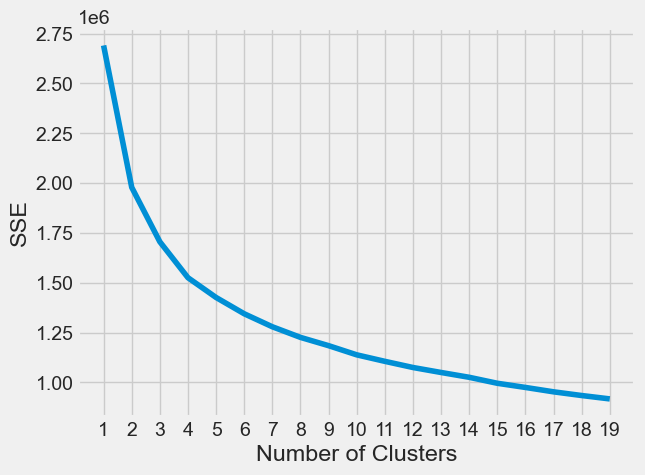

In [659]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), inercia)
plt.xticks(range(1, 20))
plt.xlabel("nº Cluster")
plt.ylabel("Inercia")
plt.show()

<h1> <h1> <span style="color:orange"><b> Capítulo 4 </b></span>- Resultados

In [2]:
df_master = pd.read_parquet("B:/Data Master/base_dados/master_table")

def depara_cluster(k):
    if k==0: return 'Alfa'
    elif k==1: return 'Beta'
    elif k==2: return 'Gama'
    elif k==3: return 'Delta'
    elif k==4: return 'Épsilon'

def escoragem_cluster(df):
    kmeans = joblib.load('B:/Data Master/model_cluster.pkl')
    X_train_scaler = df[kmeans.feature_names_in_]
    X_train_scaler[X_train_scaler.columns] = escalar_para_menos1_1(tratar_outliers(X_train_scaler))
    return kmeans.predict(X_train_scaler)

def escoragem_regressao(df):
    reg = joblib.load('B:/Data Master/model_regressao.pkl')
    return reg.predict(df[reg.feature_name_])

def escoragem_classificacao(df):
    clf = joblib.load('B:/Data Master/model_classificacao.pkl')
    return clf.predict_proba(df[clf.feature_name_])[:,0]

In [6]:
df_master['cluster'] = escoragem_cluster(df_master)
df_master['cluster'] = df_master['cluster'].apply(depara_cluster)
df_master['proj_margem_liquida'] = escoragem_regressao(df_master)
df_master['score_CHURN'] = escoragem_classificacao(df_master)

In [10]:
df_master['qtde'] = 1
df_master['class_CHURN'] = pd.cut(df_master['score_CHURN'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Muito Alta', 'Alta', 'Média','Baixa', 'Muito Baixa'])

matriz_qtde = pd.pivot_table(df_master, values='qtde', index=['class_CHURN'], columns=['cluster'], aggfunc="sum")
matriz_margem = pd.pivot_table(df_master, values='proj_margem_liquida', index=['class_CHURN'], columns=['cluster'], aggfunc="mean")

In [11]:
# avaliar o ponto de corte das classes de churn
cubo = df_master.groupby(['class_CHURN']).agg({'qtde':'sum', 'inativo_M3': 'sum'}).reset_index()
cubo['tx_inativo'] = np.round(cubo['inativo_M3']/cubo['qtde'],3)*100
cubo

,class_CHURN,qtde,inativo_M3,tx_inativo
0,Muito Alta,1687138,1636961,97.0
1,Alta,682935,288662,42.3
2,Média,904962,231069,25.5
3,Baixa,744739,98825,13.3
4,Muito Baixa,3359336,81188,2.4


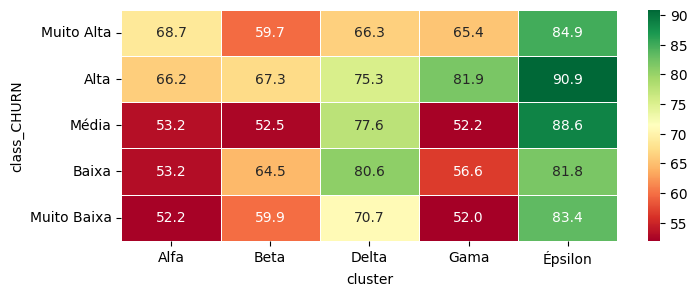

In [12]:
data = matriz_margem.apply(pd.to_numeric, errors='coerce')
plt.figure(figsize=(8, 3))
sns.heatmap(data, annot=True, fmt=".1f", cmap='RdYlGn', linewidths=.5)
plt.show()

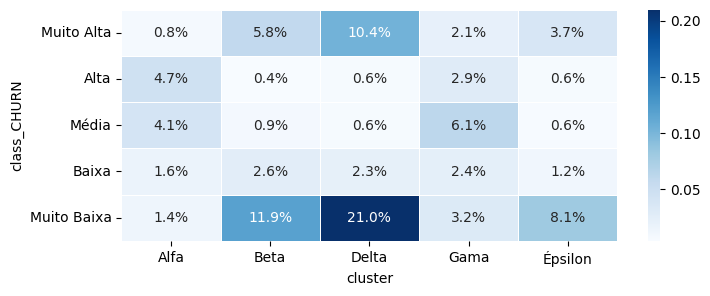

In [13]:
data = matriz_qtde.apply(pd.to_numeric, errors='coerce')
data_percentage = data.div(data.sum().sum())

plt.figure(figsize=(8, 3))
sns.heatmap(data_percentage, annot=True, fmt=".1%", cmap='Blues', linewidths=.5)
plt.show()